In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import pandas_datareader.data as web
import datetime
from random import randint

## Download data

In [64]:
a = np.array([range(20)])
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2020, 12, 31)
df = web.DataReader('^GSPC','yahoo',start,end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971


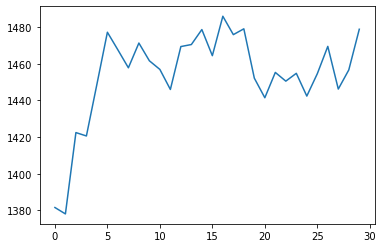

In [65]:
sp500 = df.Close.to_numpy()
sp500.shape
prices = sp500[100:130]
plt.plot(prices)

## The transformation
The Gramian Angular Field transformation
1. Scales down $x$, such that $$x_i \in [1,1]$$
2. Transforms $x$ to polar coordinates $$\theta_i = arccos(x_i)$$
3. Defines the output matrix as $$A_{ij} = cos(\theta_i \pm \theta_j)$$

Since choosing either $\theta_i+\theta_j$ or $\theta_i - \theta_j$ does not preserve signs, we choose both and stack the two resulting matrices to form an RGB _(or rather an RG)_ image.

In [69]:
class GAF:
    def __init__(self, trig='sin'):
        if trig=='sin':
            self._trig = np.sin
            self._rev_trig = np.arcsin
        elif trig=='cos':
            self._trig = np.cos
            self._rev_trig = np.arccos
    
    def _scale(self, arr):
        return np.interp(arr, (arr.min(), arr.max()), (-1,1))
    
    def transform(self, arr):
        arr = self._scale(arr)
        arr = self._rev_trig(arr)
        mat = np.add.outer(arr,arr)
        mat = self._trig(mat)
        return mat
    
    def reverse(self, mat):
        ...

In [71]:
def transform(arr):
    sin_gaf = GAF(trig='sin')
    cos_gaf = GAF(trig='cos')
    sin_mat = sin_gaf.transform(arr)
    cos_mat = cos_gaf.transform(arr)
    sin_mat = (sin_mat+np.ones_like(sin_mat))/2
    cos_mat = (cos_mat+np.ones_like(cos_mat))/2
    return np.dstack((sin_mat, cos_mat, np.zeros_like(sin_mat)))

def visualize(arr):
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(arr)
    ax2.matshow(transform(arr))

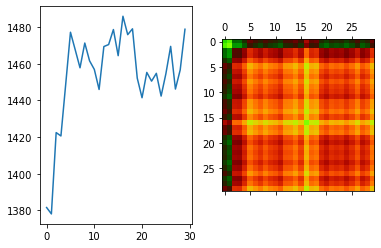

In [72]:
visualize(prices)

## Reverting the transformation
Since reversion (and transformation for that matter) will only take place when a chosen matrix is generated, we don't need to worry about optimisation and can use branching.
Based on the signs of $R_{ij}$ and $G_{ij}$, we find the quadrant of the sum
Then, to get the absolute value, we take the $arccos$ of the matrices, leaving
$$R_{ij} = \theta_i+\theta_j$$